<a href="https://www.kaggle.com/code/alpacatony/fraud-detection-21-1-2023?scriptVersionId=116984164" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
df = pd.read_csv('/kaggle/input/paysim1/PS_20174392719_1491204439457_log.csv')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/paysim1/PS_20174392719_1491204439457_log.csv


In [2]:
"""
1,PAYMENT,1060.31,C429214117,1089.0,28.69,M1591654462,0.0,0.0,0,0

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount - amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.
"""

'\n1,PAYMENT,1060.31,C429214117,1089.0,28.69,M1591654462,0.0,0.0,0,0\n\nstep - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).\n\ntype - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.\n\namount - amount of the transaction in local currency.\n\nnameOrig - customer who started the transaction\n\noldbalanceOrg - initial balance before the transaction\n\nnewbalanceOrig - new balance after the transaction\n\nnameDest - customer who is the recipient of the transaction\n\noldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).\n\nnewbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).\n\nisFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit 

### Goal & Steps
Train our model to detect fraud transactions
1. Check our columns and figure out the meaning of each column
2. Find out how many frauds are in the dataset
3. Read up on how fraud detection can be done?
4. Create a heatmap to check correlations
4. Create features to detect fraud
5. Split the data into a training set and testing set
6. Normalize our features & fit Logistic Regression model
7. Check train/test scores



In [3]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
print('shape:', df.shape) #offline mode it is (rendering is too slow)
# how many frauds are there?
print('fraud count:',df.isFraud.sum()) 


shape: (6362620, 11)
fraud count: 8213


In [5]:
# Detecting fraud by checking the difference of old balance sender
## with old balance of reciever

# CASH_OUT & TRANSFER are two methods for moving money out
df.type.value_counts()
#df['cashmovement'] = df[df.type.isin(['CASH_OUT', 'TRANSFER')]]
df['cashmovement'] = df.type.apply(lambda x: 1 if x in('CASH_OUT','TRANSFER') else (0))
df.cashmovement.value_counts()

0    3592211
1    2770409
Name: cashmovement, dtype: int64

In [6]:
# Finalize our features
df['balanceDiff'] = np.abs(df.oldbalanceOrg - df.oldbalanceDest)
features_list = ['amount', 'balanceDiff','cashmovement']
features = df[features_list]
label = df.isFraud
# Check correlations before we move on with the selected features
numdf = df.select_dtypes(exclude='object')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,cashmovement,balanceDiff
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0,170136.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0,21249.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,1,181.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,1,21001.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0,41554.0


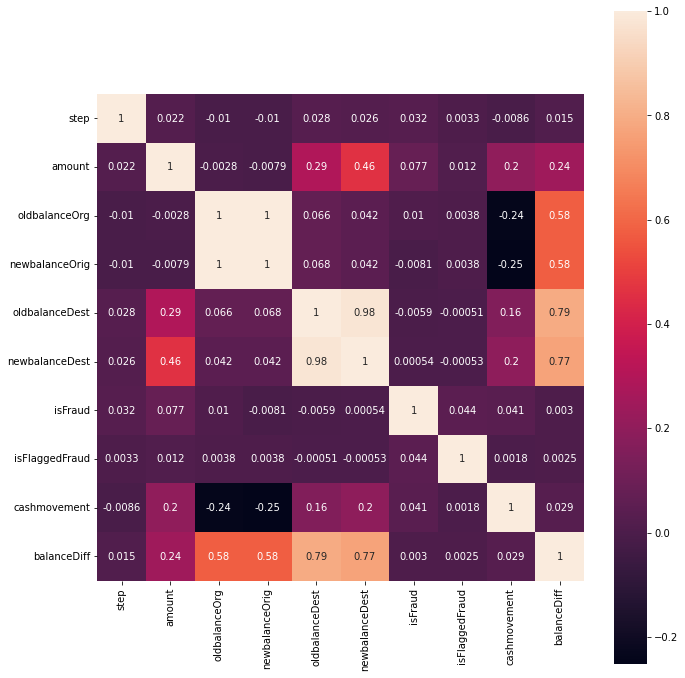

<Figure size 432x288 with 0 Axes>

In [7]:
# Creating a heatmap to check for correlations we might want to use
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(numdf.corr(), annot=True, cbar_kws={'shrink':1}, square=True, ax=ax)
plt.tight_layout()
ax.set_aspect('equal')
plt.show()
plt.clf()

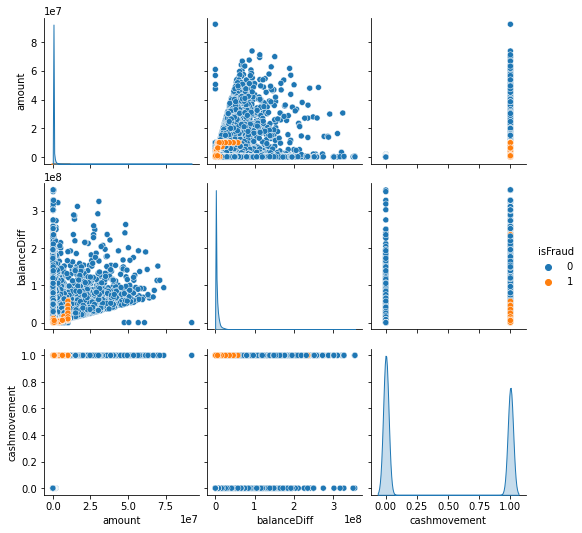

<Figure size 432x288 with 0 Axes>

In [8]:
# Pairplot to be thorough
sns.pairplot(data=numdf, hue='isFraud', vars=features)
plt.show()
plt.clf()

In [9]:
#Split test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=.2)

#Import & Normalize Features
from sklearn.preprocessing import StandardScaler
model = StandardScaler()
X_train = model.fit_transform(X_train)
X_test = model.fit_transform(X_test)

#Logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [10]:
#Train Score
print(lr.score(X_train, y_train))


0.9986878440013705


In [11]:
#Test Score... thats pretty high?
print(lr.score(X_test, y_test))

0.9987049360169239


In [12]:
# Confusion Matrix
y_predict = lr.predict(X_test)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_predict))

#[TN FP
# FN TP]

[[1270876      20]
 [   1628       0]]


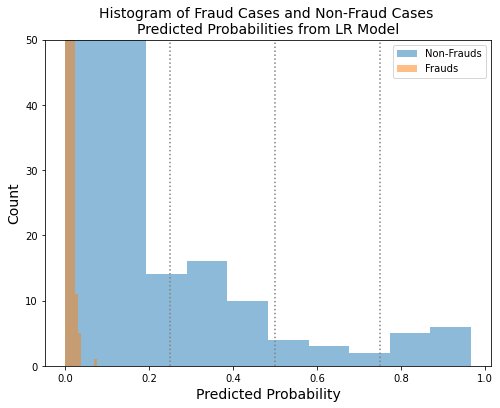

In [13]:
# Let's visually show the probability of finding frauds
y_pred_prob = lr.predict_proba(X_test)
plt.figure(figsize=(8,6))
plt.hist(y_pred_prob[y_test==0,1], alpha=.5, label='Non-Frauds',)
plt.hist(y_pred_prob[y_test==1,1], alpha=.5 , label='Frauds')
plt.xlabel('Predicted Probability', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.plot([.25, .25],[0,50],color='grey', linestyle=':')
plt.plot([.5, .5],[0,50],color='grey', linestyle=':')
plt.plot([.75, .75],[0,50],color='grey', linestyle=':')
plt.ylim([0,50])
plt.legend()
plt.title('Histogram of Fraud Cases and Non-Fraud Cases \nPredicted Probabilities from LR Model', fontsize=14)
plt.show()